# Detecting Tumors in MRI Brain Scans with Convolutional Neural Networks

## Table of Contents
#### • [Business Understanding](#Business-Understanding)
#### • [Data Understanding](#Data-Understanding)
#### • [Data Science Process](#Data-Science-Process)
#### • [Conclusion](#Conclusion)

# Business Understanding <a id='Business-Understanding'></a>

According to the [National Institute of Health](https://www.ninds.nih.gov/Disorders/Patient-Caregiver-Education/Hope-Through-Research/Brain-and-Spinal-Tumors-Hope-Through#definition), "[brain tumors] occur when something goes wrong with genes that regulate cell growth, allowing cells to grow and divide out of control... Depending on its type, a growing tumor may not cause any symptoms or can kill or displace healthy cells or disrupt their function" (Brain and Spinal Cord Tumors, 2020).

The process for diagnosing brain tumors include an initial neurological exam, and then imaging methods including MRI scans. Currently, images are analyzed by MRI technicians before being sent to the doctor for a final analysis. If necessary, a biopsy is done to confirm a diagnosis. A biopsy is a surgical procedure where a small sample of tissue is extracted. Depending on the location of the suspected tumor, this can be dangerous to the patient, or impossible to perform if in a particularly sensitive area.

With advances in image classification techniques, preliminary analyses can be aided by computers through algorithms like those employed in this project. This can reduce the need for potentially dangerous biopsies, allowing doctors and patients to focus on the next step, treatment. Doctors, patients, and MRI technicians stand to benefit from classification algorithms.

# Data Understanding

Thousands of MRI brain scans were used in this project. The scans were sourced from two Kaggle datasets and BrainDevelopment.org: [Kaggle 2018](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection), [Kaggle 2020](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri), and [BrainDevelopment.org](https://brain-development.org/ixi-dataset/).
Included in these are scans of various section and scan types and brains with and without tumors present. The three types of sections included are frontal, medial, and horizontal.

Various scan types include Proton Density and Transverse Magnetization. Different types of scans are useful for detecting different types of tissue in different regions of the brain. Some tissue types are more visible under contrast material or propagate magnetization differently.

In this project, a scan without a tumor was considered Class 0, and a scan with a tumor present was considered Class 1. As a result, recall score was the prioritized along with accuracy in this type of neural network, as the effects of false negative can be much more harmful than a false positive.

# Data Science Process <a id='Data-Science-Process'></a>
### This notebook contains the code necessary to load and classify MRI images as containing a brain tumor or being tumor-free.
#### The process is as follows:
- [Import libraries and functions](#Imports)
- [Data Preparation](#Data-Preparation)
 - [Get image paths and split into three groups for neural network compatibility (train, validation, test)](#Get-Image-Paths)
 - [Load images and remove duplicates](#Load-Image-Data)
 - [Reshape data for neural network compatibility ](#Reshape-Image-Data)
 - [Use ImageDataGenerator to resample and alter training images model more robust](#ImageDataGenerator)
- [Modeling](#Modeling)
 - [Build and train model](#First-Simple-Model-(FSM))
 - [Visualize model performance](#Visualize-Model-Performance)
 - [Analyze model performance with LIME](#Analyze-Model-Performance)

## Imports 

In [1]:
# import libraries/packages
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from skimage.segmentation import mark_boundaries
import math 
import lime.lime_image as li

## Data Preparation

After sourcing data, paths to the images were saved and used to split data into train, validation, and testing images. Using the paths, images were loaded using openCV and duplicates were removed with custom functions. The images were then resized and reshaped to work with the format of Convolutional Neural Network.
To create a more robust model, ImageDataGenerator was used to create slightly altered images used in tandem with original images while training the model.

In [2]:
# import custom functions
import sys
sys.path.append('../../src')

from data_functions import *

# Get Image Paths

### Custom function returns all image files within given directory

In [3]:
# get paths from base directory
base_dir = 'D:/MRI_data/Kaggle'
absent_paths, present_paths = get_img_paths(base_dir)

### Split Paths into Train, Validation, and Test sets with sklearn train_test_split

In [4]:
# define train size for data set
train_size = 0.8 # eighty percent
test_size = 0.15 # fifteen percent
val_size = 0.05 # five percent

# calculate test size for second split
test_size2 = test_size/(1-train_size)

# split absent paths into train and test
absent_train, absent_test = train_test_split(absent_paths, train_size=train_size, random_state=2021)

# split absent test paths into test and validation
absent_test, absent_val = train_test_split(absent_test, train_size=test_size2, random_state=2021)

# split present paths into train and test
present_train, present_test = train_test_split(present_paths, train_size=train_size, random_state=2021)

# split present paths into test and val
present_test, present_val = train_test_split(present_test, train_size=test_size2, random_state=2021)

In [5]:
# combine train and test and validation lists (respectively)
train = absent_train
train.extend(present_train)

test = absent_test
test.extend(present_test)

val = absent_val
val.extend(present_val)

# Load Image Data
### Custom function loads data given path and class specified

In [6]:
# load image data
train_img_data = get_data(train)

val_img_data = get_data(val)

test_img_data = get_data(test)

# Remove Duplicates
### Custom function compares each image and removes duplicates.

In [7]:
# remove duplicates from each set
unique_train_img, train_duplicate = remove_duplicates(train_img_data)
unique_val_img, val_duplicate = remove_duplicates(val_img_data)
unique_test_img, test_duplicate = remove_duplicates(test_img_data)

### View samples of scans with and without tumors present

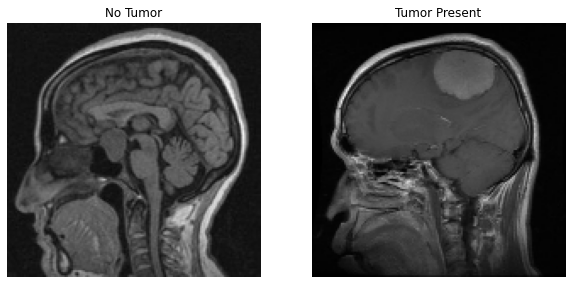

In [8]:
plt.rcParams["savefig.transparent"] = True
labels = ['No Tumor', 'Tumor Present']

# create figure hold images
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax = ax.flatten()
# plot image data from first [1] train image data (tumor-free brain)
ax[0].imshow(unique_train_img[100][0], cmap='gray')
ax[0].set_title(labels[unique_train_img[100][1]])
ax[0].axis('off')

# plot image data from last [-1] train image data (tumor patient brain)

ax[1].imshow(unique_train_img[-22][0], cmap='gray')
ax[1].set_title(labels[unique_train_img[-22][1]])
ax[1].axis('off')

# save figure
plt.savefig("scan_comparison.png", transparent=True)

# Reshape Image Data

In [9]:
# separate image data and identifiers
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for data, label, _ in unique_train_img:
    x_train.append(data)
    y_train.append(label)
    
for data, label, _ in unique_val_img:
    x_val.append(data)
    y_val.append(label)
    
for data, label, _ in unique_test_img:
    x_test.append(data)
    y_test.append(label)

In [10]:
# scale data and convert to np.array for efficiency

x_train = np.array(x_train)/255

x_test = np.array(x_test)/255

x_val = np.array(x_val)/255

In [11]:
img_size = 150

# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 3)

x_test = x_test.reshape(-1, img_size, img_size, 3)

x_val = x_val.reshape(-1, img_size, img_size, 3)

## ImageDataGenerator

In [12]:
no_datagen = ImageDataGenerator(\
                            featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False, 
                            zca_whitening=False, 
                            rotation_range=0,
                            zoom_range=0,
                            width_shift_range=0,
                            height_shift_range=0,
                            horizontal_flip=False,
                            vertical_flip=False)

# Modeling

A Convolutional Neural Network makes it possible to process images in the form of pixels as input and to predict the desired classification as output. The development of Convolutional Neural Network (CNN) layers trains a model for significant gains in the ability to classify images and detect objects in a picture. Multiple processing layers use image analysis filters, or convolutions as the model is trained.

The convolutional layers help extract the spatial features in an image. The layers have a weight-sharing technique, which helps in reducing computation efforts.

A Convolution Neural Network (CNN) is built on three broad strategies:

  1) Learn features using Convolution layer

  2) Reduce computational costs by down sample the image and reduce dimensionality using Max-Pooling(subsampling)

  3) Fully connected layer to equip the network with classification capabilities

## Model

In [13]:
learning_rate_reduction_loss = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_lr=10**-9)
learning_rate_reduction_acc = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=10**-9)

In [14]:
metrics = ['Recall', 'accuracy']
model = Sequential()
model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(150,150,3)))
model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
flatten (Flatten)            (None, 720000)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 720001    
Total params: 720,897
Trainable params: 720,897
Non-trainable params: 0
_________________________________________________________________


In [15]:
epochs = 30
model_history = model.fit(no_datagen.flow(x_train, y_train), epochs=epochs, validation_data=no_datagen.flow(x_val, y_val), callbacks=[learning_rate_reduction_loss, learning_rate_reduction_acc])

Epoch 1/30
80/80 [==============================] - 14s 175ms/step - loss: 0.6157 - recall: 0.9569 - accuracy: 0.8457 - val_loss: 0.2765 - val_recall: 0.9863 - val_accuracy: 0.8857
Epoch 2/30
80/80 [==============================] - 14s 172ms/step - loss: 0.1592 - recall: 0.9803 - accuracy: 0.9374 - val_loss: 0.2216 - val_recall: 0.9795 - val_accuracy: 0.9029
Epoch 3/30
80/80 [==============================] - 14s 169ms/step - loss: 0.0615 - recall: 0.9940 - accuracy: 0.9811 - val_loss: 0.2073 - val_recall: 0.9452 - val_accuracy: 0.9200
Epoch 4/30
80/80 [==============================] - 13s 168ms/step - loss: 0.0208 - recall: 0.9991 - accuracy: 0.9953 - val_loss: 0.2260 - val_recall: 0.9932 - val_accuracy: 0.9429
Epoch 5/30
80/80 [==============================] - 14s 170ms/step - loss: 0.0069 - recall: 1.0000 - accuracy: 1.0000 - val_loss: 0.1931 - val_recall: 0.9658 - val_accuracy: 0.9371
Epoch 6/30
80/80 [==============================] - ETA: 0s - loss: 0.0036 - recall: 1.0000 - a

# Visualize Performance
## Display changes in accuracy by epoch to help understand model learning progress

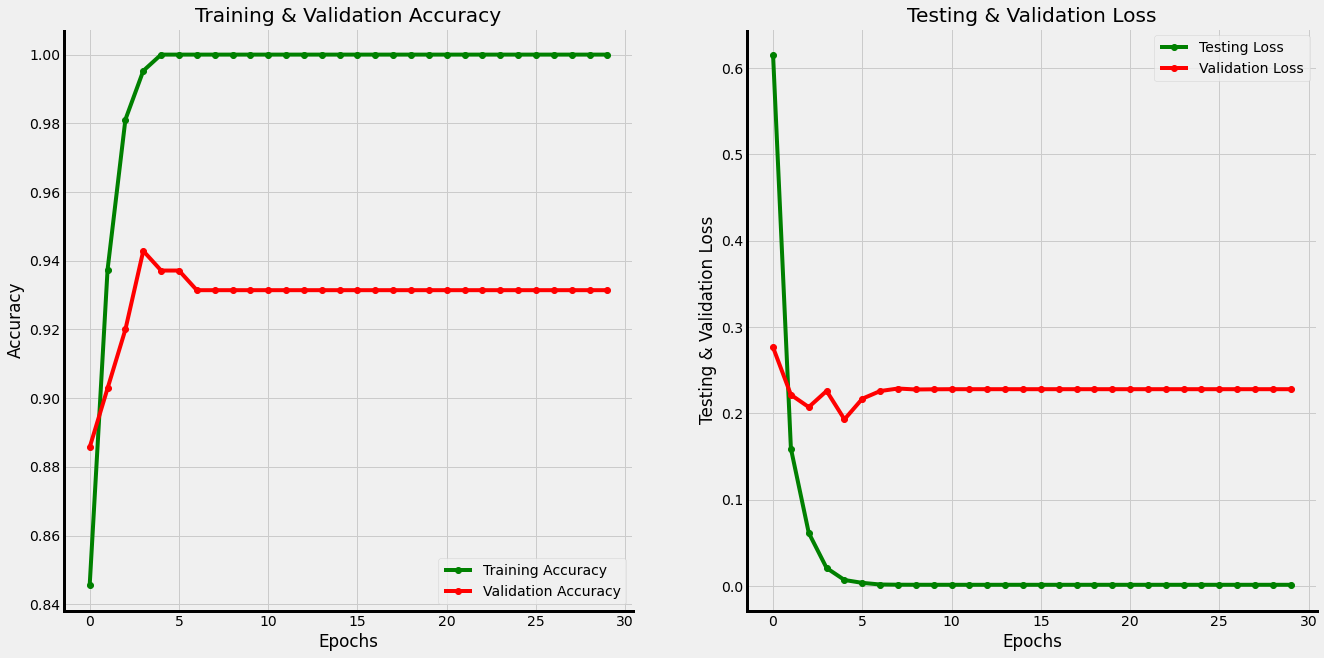

In [16]:
plot_metrics(model.history, path='../figures/metrics_model')

## Create a confusion matrix to represent the model's correct and incorrect predictions

              precision    recall  f1-score   support

    No Tumor       0.91      0.90      0.91        81
       Tumor       0.98      0.98      0.98       429

    accuracy                           0.97       510
   macro avg       0.95      0.94      0.94       510
weighted avg       0.97      0.97      0.97       510

[[ 73   8]
 [  7 422]]


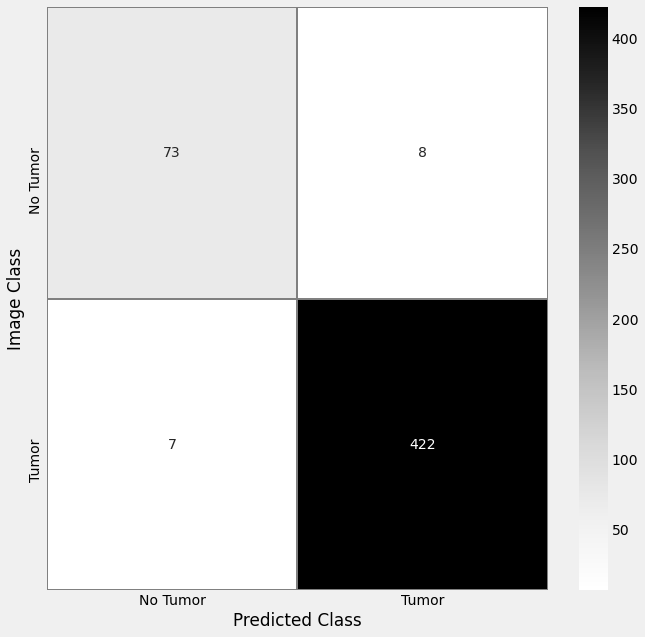

In [17]:
plot_confusion_matrix(model, x_test, y_test, path='../figures/confusion_matrix_model')

# Analyze Model Performance

### Get all image classifications and compare to predictions. Store to identify error types.

In [18]:
# get model predictions
predictions = (model.predict(x_test) > 0.5).astype('int32')

# identify image classifications
good_preds0 = []
good_preds1 = []
type_1 = []
type_2 = []

for i in range(len(y_test)):
    
    if y_test[i] == predictions[i]:
        if y_test[i] == 0:
            good_preds0.append(i)
        
        else:
            good_preds1.append(i)
    
    elif y_test[i] == 1:
        type_1.append(i)
        
    else:
        type_2.append(i)
        
good_preds0 = np.array(good_preds0)
good_preds1 = np.array(good_preds1)
type_1 = np.array(type_1)
type_2 = np.array(type_2)

## TIME for LIME
### Use LIME techniques to visualize model's analysis of images

To better understand how the model is classifying the images, implement LIME. LIME is an acronym for Local Interpretable Model-agnostic Explanations. The way LIME works is it breaks the image into several regions, called "superpixels", and the model classifies the image with the various superpixels turned on and off. Superpixels are then given weights based on their importance to the model's classification. Below are patient scans with tumors present. Using LIME, we see with the superpixel the model had given the most weight is picking up on the region containing the tumor, evidence the model is picking up on relevant regions when identifying the presence of tumors.
(Note, this is not true for all images in dataset, particularly those misclassified)

rows: 1  columns: 2
len(ax) = 2
m_end: 2  n_end: 0


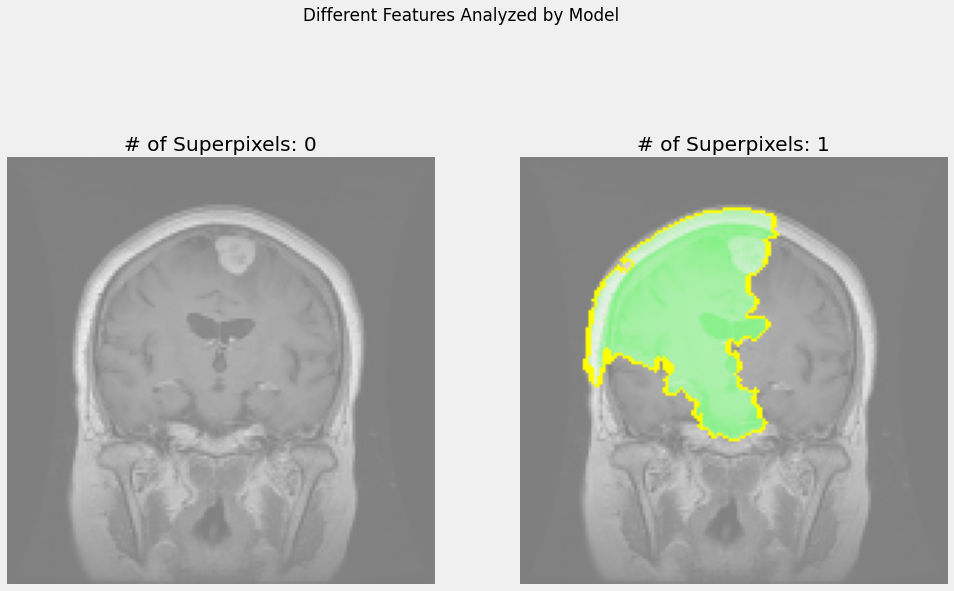

In [19]:
num = 21
lime_image(model, x_test[good_preds1[num]], min_superpixels=0, max_superpixels=2, path=f'../figures/tumor_correct[{num}]', figsize=(15,10))

rows: 1  columns: 2
len(ax) = 2
m_end: 2  n_end: 0


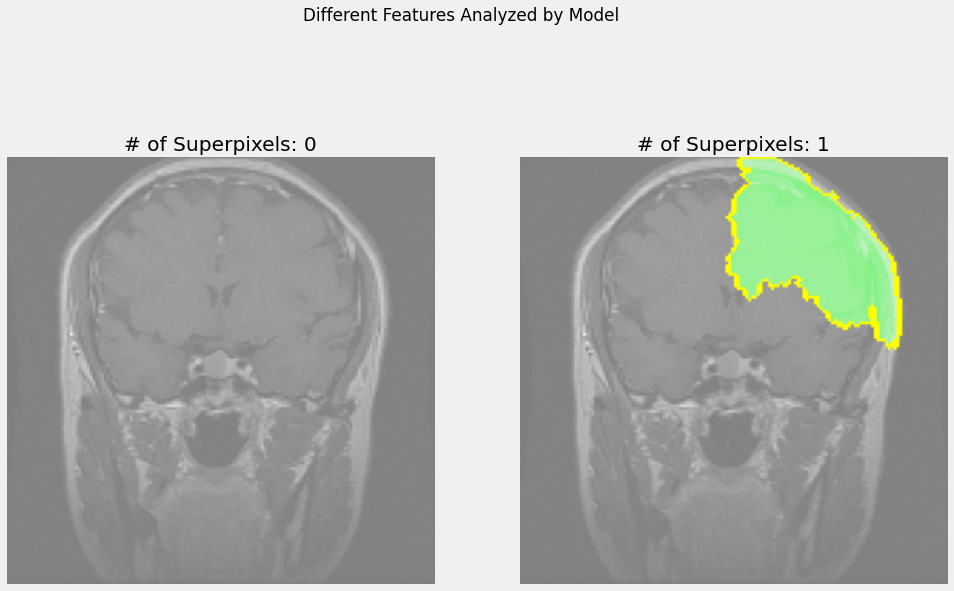

In [20]:
num = 22
lime_image(model, x_test[good_preds1[num]], min_superpixels=0, max_superpixels=2, path=f'../figures/tumor_correct[{num}]', figsize=(15,10))

rows: 1  columns: 2
len(ax) = 2
m_end: 2  n_end: 0


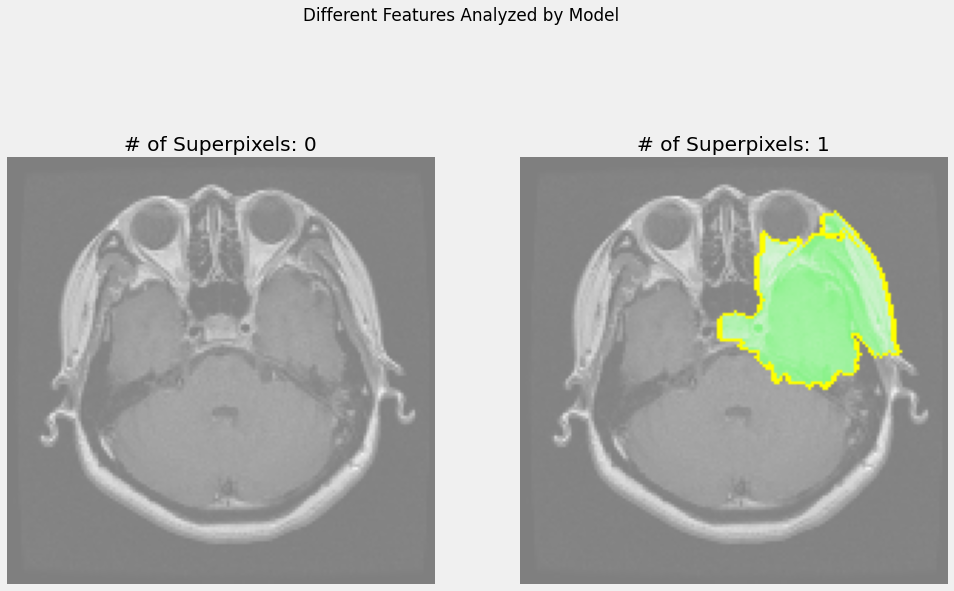

In [21]:
num = 23
lime_image(model, x_test[good_preds1[num]], min_superpixels=0, max_superpixels=2, path=f'../figures/tumor_correct[{num}]', figsize=(15,10))

rows: 1  columns: 2
len(ax) = 2
m_end: 2  n_end: 0


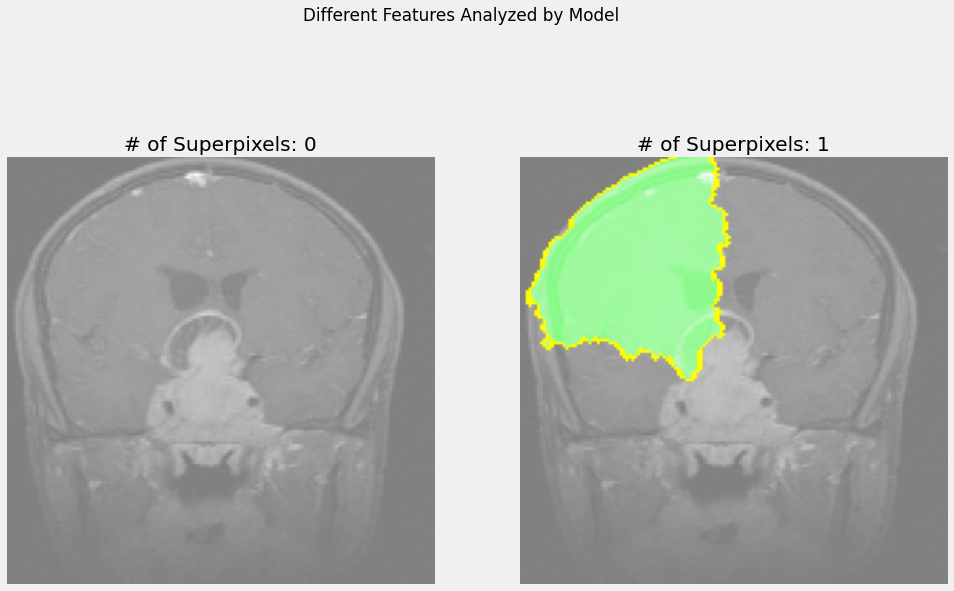

In [22]:
num = 24
lime_image(model, x_test[good_preds1[num]], min_superpixels=0, max_superpixels=2, path=f'../figures/tumor_correct[{num}]', figsize=(15,10))

rows: 1  columns: 2
len(ax) = 2
m_end: 2  n_end: 0


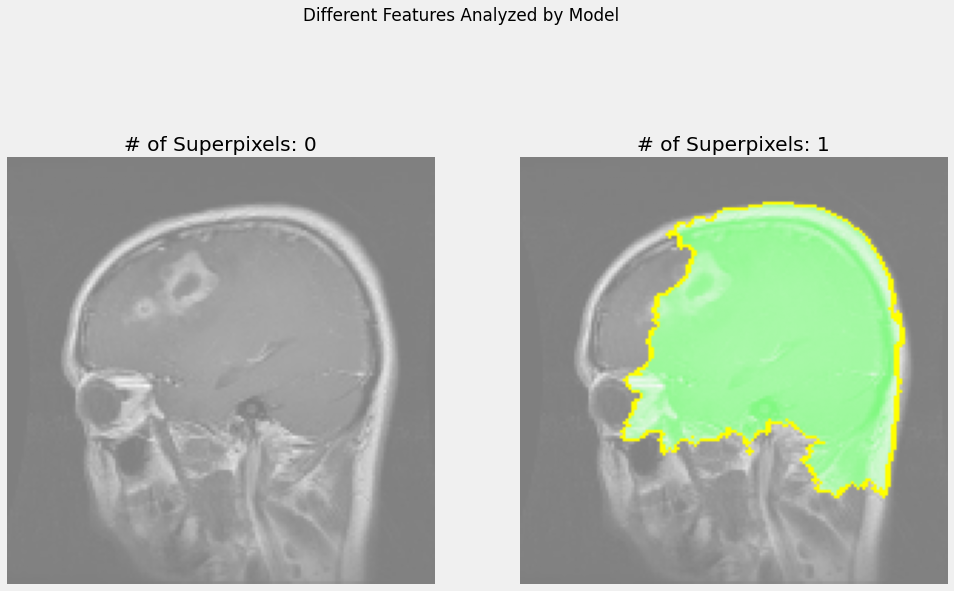

In [23]:
num = 27
lime_image(model, x_test[good_preds1[num]], min_superpixels=0, max_superpixels=2, path=f'../figures/tumor_correct[{num}]', figsize=(15,10))

rows: 1  columns: 2
len(ax) = 2
m_end: 2  n_end: 0


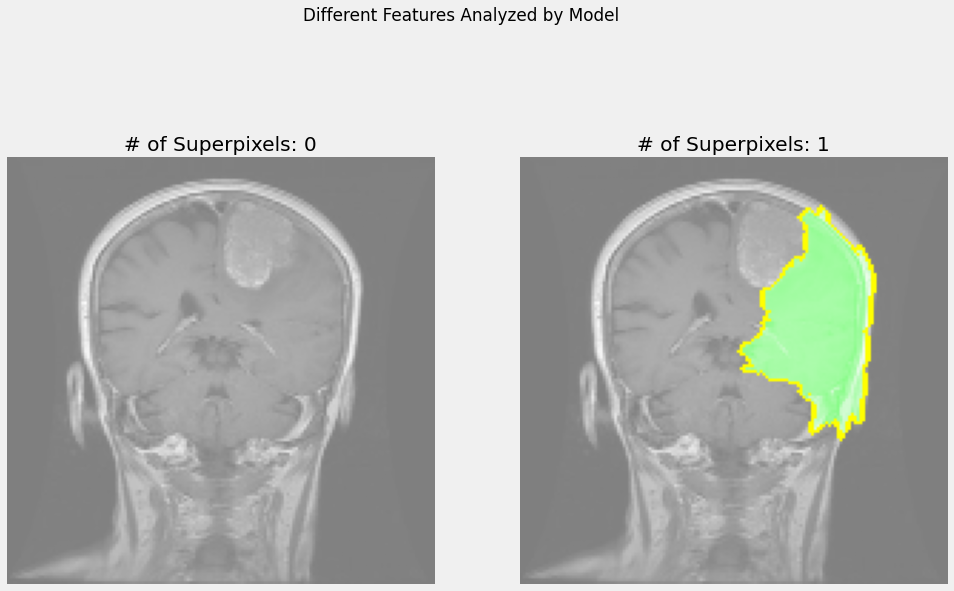

In [24]:
num = 28
lime_image(model, x_test[good_preds1[num]], min_superpixels=0, max_superpixels=2, path=f'../figures/tumor_correct[{num}]', figsize=(15,10))

rows: 1  columns: 2
len(ax) = 2
m_end: 2  n_end: 0


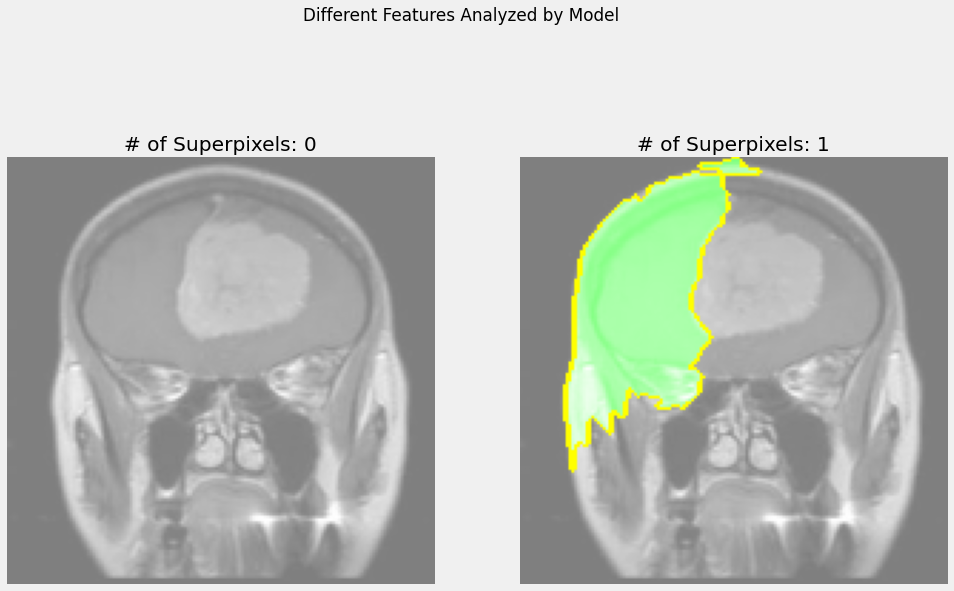

In [25]:
num = 32
lime_image(model, x_test[good_preds1[num]], min_superpixels=0, max_superpixels=2, path=f'../figures/tumor_correct[{num}]', figsize=(15,10))

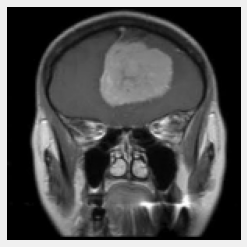

In [26]:
plt.rcParams["savefig.transparent"] = True
labels = ['No Tumor', 'Tumor Present']

# create figure hold images
fig, ax = plt.subplots()
# plot image data from first [1] train image data (tumor-free brain)
ax.imshow(x_test[good_preds1[32]], cmap='gray')
# ax[0].set_title(labels[unique_train_img[100][1]])
ax.axis('off')

# save figure
plt.savefig("../../report/figures/identified.png", transparent=True)

rows: 1  columns: 2
len(ax) = 2
m_end: 2  n_end: 0


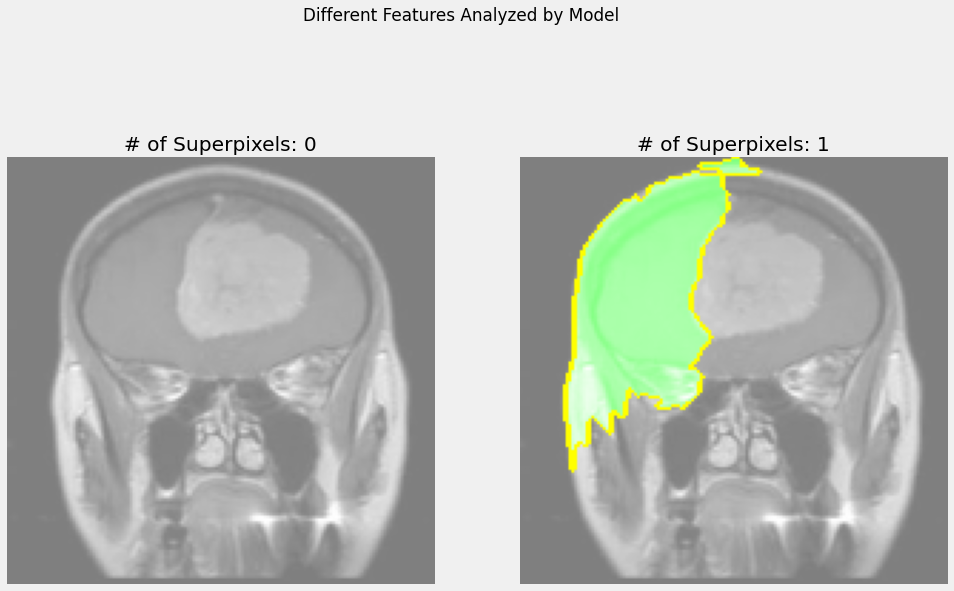

In [27]:
num = 32
lime_image(model, x_test[good_preds1[num]], min_superpixels=0, max_superpixels=2, path=f'../figures/tumor_correct[{num}]', figsize=(15,10))

# Conclusion <a id='Conclusion'></a>

Between the CNN's shown, we've seen good recall and improved accuracy. This weas followed by verification with LIME that the model is detecting areas with tumors. With more data and tuning, the model shows potential for higher accuracy and recall. In addition, creating variations of the model may lead to more advanced diagnoses, such as classify tumors by location, and determining if a tumor is benign or malignant.